In [45]:
import tensorflow as tf
# Explicitly disable eager execution
tf.compat.v1.disable_eager_execution()

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar100

import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# from keras.utils import np_utils
# from keras.datasets import mnist
# from keras.models import Sequential
# from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow_addons.optimizers import AdamW, Yogi 
import tensorflow as tf
import time
import pandas as pd
import cv2
from sklearn.preprocessing import OneHotEncoder

C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\werka\miniconda3\envs\py310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If 

In [2]:
# # Enable logging of device placement
# tf.debugging.set_log_device_placement(True)

In [3]:

# # Load and preprocess CIFAR-100 data
# (x_train, y_train), (x_test, y_test) = cifar100.load_data()
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Define the class indices for "Vehicles 1"
# vehicles_1_indices = [8, 14, 48, 59, 91]

# # Filter function to select data by specified class indices
# def filter_classes(x_data, y_data, class_indices):
#     mask = np.isin(y_data, class_indices).flatten()
#     return x_data[mask], y_data[mask]

# # Apply the filter function to both training and test sets
# x_train_vehicles, y_train_vehicles = filter_classes(x_train, y_train, vehicles_1_indices)
# x_test_vehicles, y_test_vehicles = filter_classes(x_test, y_test, vehicles_1_indices)

# # Split the training data into training and validation sets
# x_train_vehicles, x_val_vehicles, y_train_vehicles, y_val_vehicles = train_test_split(
#     x_train_vehicles, y_train_vehicles, test_size=0.2, random_state=42
# )

# # Print the sizes of each dataset
# print("Vehicles 1 - Training size:", len(x_train_vehicles))
# print("Vehicles 1 - Validation size:", len(x_val_vehicles))
# print("Vehicles 1 - Test size:", len(x_test_vehicles))

The "Food containers" superclass includes these five classes with their corresponding indices:

Bottle: 10
Bowl: 11
Can: 17
Cup: 29
Plate: 62

In [4]:
# Load CIFAR-100 data
(x_train, y_train), (x_test, y_test) = cifar100.load_data()

# Normalize the images by scaling pixel values to [0, 1]
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Define the class indices for "Flowers"
flowers_indices = [55, 63, 71, 83, 92]

# Filter function to select data by specified class indices
def filter_classes(x_data, y_data, class_indices):
    mask = np.isin(y_data, class_indices).flatten()
    filtered_x = x_data[mask]
    filtered_y = np.array([class_indices.index(label[0]) for label in y_data[mask]])
    return filtered_x, filtered_y

# Apply the filter function to both training and test sets
x_train_vehicles, y_train_vehicles = filter_classes(x_train, y_train, flowers_indices)
X_test, y_test = filter_classes(x_test, y_test, flowers_indices)

# Split the training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    x_train_vehicles, y_train_vehicles, test_size=0.2, random_state=42
)

# One-hot encode the class labels for training and validation datasets
y_train = to_categorical(y_train, num_classes=len(flowers_indices))
y_val = to_categorical(y_val, num_classes=len(flowers_indices))
y_test = to_categorical(y_test, num_classes=len(flowers_indices))

# Print the sizes of each dataset
print("Vehicles 1 - Training dataset size:", len(X_train))
print("Vehicles 1 - Validation dataset size:", len(X_val))
print("Vehicles 1 - Test dataset size:", len(X_test))

Vehicles 1 - Training dataset size: 2000
Vehicles 1 - Validation dataset size: 500
Vehicles 1 - Test dataset size: 500


In [5]:
X_train.shape

(2000, 32, 32, 3)

In [6]:
# # Usage
# preprocessor = CNNDataPreprocessor()
# X_train, y_train, X_val, y_val, X_test, y_test = preprocessor.load_data()

In [7]:
# # Define reduction percentages
# reduction_percentage = 0.7

# # Reduce the size of the datasets
# X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=reduction_percentage, random_state=42)
# X_val, _, y_val, _ = train_test_split(X_val, y_val, test_size=reduction_percentage, random_state=42)
# X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=reduction_percentage, random_state=42)

In [8]:
X_train.shape , X_val.shape, X_test.shape

((2000, 32, 32, 3), (500, 32, 32, 3), (500, 32, 32, 3))

In [9]:
# Define the NeuralNetworkModel class
class NeuralNetworkModel:
    def __init__(self):
        self.model = None

    def build_cnn(self, input_shape, num_classes, optimizer):
        """Build a CNN model compatible with CIFAR-10 data."""
        self.model = Sequential()
        self.model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))
        self.model.add(Dense(num_classes, activation='softmax'))
        self.model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        
    def train(self, X_train, y_train, X_val, y_val, epochs, batch_size):
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        return self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                              validation_data=(X_val, y_val), callbacks=[early_stopping, reduce_lr])

    def evaluate(self, X_test, y_test):
        y_pred_prob = self.model.predict(X_test)
        y_pred = np.argmax(y_pred_prob, axis=1)
        y_true = np.argmax(y_test, axis=1)
        accuracy = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred, average='weighted')
        recall = recall_score(y_true, y_pred, average='weighted')
        f1 = f1_score(y_true, y_pred, average='weighted')
        return accuracy, precision, recall, f1

In [10]:
# # Load the CIFAR-10 dataset
# (x_train, y_train), (x_test, y_test) = cifar10.load_data()

# # Normalize images to range [0, 1]
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0

# # Split the training set into training and validation sets
# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


In [11]:
# # Print shapes to verify splits
# print("Training Set: ", x_train.shape, y_train.shape)
# print("Validation Set: ", x_val.shape, y_val.shape)
# print("Test Set: ", x_test.shape, y_test.shape)

In [12]:
# # One-hot encoding of the labels
# num_classes = 10
# y_train = to_categorical(y_train, num_classes)
# y_val = to_categorical(y_val, num_classes)
# y_test = to_categorical(y_test, num_classes)

In [13]:
# x_train.shape

In [14]:
(x_train.shape[1], x_train.shape[2],x_train.shape[3])

(32, 32, 3)

In [16]:
# List of optimizers to test for NN
optimizers = {
    'SGD': SGD(),
    'SGD_momentum': SGD(momentum=0.9),
    'Nesterov': SGD(momentum=0.9, nesterov=True),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adam': Adam(),
    'AMSGrad': Adam(amsgrad=True),
    'AdamW': AdamW(weight_decay=1e-4),
    'Yogi': Yogi(),
    'Nadam': tf.keras.optimizers.Nadam(),
    'Adamax': tf.keras.optimizers.Adamax()
}

results = {}

neural_network_model = NeuralNetworkModel()

for name, optimizer in optimizers.items():
    print(f"Training model with {name} optimizer...")
    neural_network_model = NeuralNetworkModel()
    # neural_network_model.build_ann(input_shape=(X_train.shape[1], X_train.shape[2]), optimizer=optimizer)
    neural_network_model.build_cnn(input_shape=(X_train.shape[1], X_train.shape[2],X_train.shape[3]), num_classes=5, optimizer=optimizer)
    start_time = time.time()
    history = neural_network_model.train(X_train, y_train, X_val, y_val, epochs=50, batch_size=32)
    end_time = time.time()
    test_accuracy, precision, recall, f1 = neural_network_model.evaluate(X_test, y_test)
    training_time = end_time - start_time
    convergence_speed = len(history.history['loss'])
    results[name] = {
        'test_accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'convergence_speed': convergence_speed,
        'training_time': training_time,
        'history': history
    }

Training model with SGD optimizer...
Epoch 1/50
63/63 [==============================] - 1s 11ms/step - loss: 1.5757 - accuracy: 0.3250 - val_loss: 1.5324 - val_accuracy: 0.4580 - lr: 0.0100
Epoch 2/50
63/63 [==============================] - 0s 5ms/step - loss: 1.4556 - accuracy: 0.4420 - val_loss: 1.3535 - val_accuracy: 0.4520 - lr: 0.0100
Epoch 3/50
63/63 [==============================] - 0s 5ms/step - loss: 1.2667 - accuracy: 0.4920 - val_loss: 1.1970 - val_accuracy: 0.5560 - lr: 0.0100
Epoch 4/50
63/63 [==============================] - 0s 5ms/step - loss: 1.1648 - accuracy: 0.5310 - val_loss: 1.1446 - val_accuracy: 0.5480 - lr: 0.0100
Epoch 5/50
63/63 [==============================] - 0s 6ms/step - loss: 1.1166 - accuracy: 0.5580 - val_loss: 1.1749 - val_accuracy: 0.4940 - lr: 0.0100
Epoch 6/50
63/63 [==============================] - 0s 6ms/step - loss: 1.0628 - accuracy: 0.5725 - val_loss: 1.0333 - val_accuracy: 0.5820 - lr: 0.0100
Epoch 7/50
63/63 [==========================

In [20]:
# Print results
print("\nResults:")
for name, result in results.items():
    print(f"{name}: Test Accuracy - {result['test_accuracy']:.4f}, "
          f"Precision - {result['precision']:.4f}, "
          f"Recall - {result['recall']:.4f}, "
          f"F1-score - {result['f1_score']:.4f}, "
          f"Convergence Speed - {result['convergence_speed']} epochs, "
          f"Training Time - {result['training_time']:.2f} seconds")


Results:
SGD: Test Accuracy - 0.7680, Precision - 0.7709, Recall - 0.7680, F1-score - 0.7666, Convergence Speed - 50 epochs, Training Time - 17.75 seconds
SGD_momentum: Test Accuracy - 0.7800, Precision - 0.7840, Recall - 0.7800, F1-score - 0.7791, Convergence Speed - 23 epochs, Training Time - 8.41 seconds
Nesterov: Test Accuracy - 0.7920, Precision - 0.7948, Recall - 0.7920, F1-score - 0.7895, Convergence Speed - 23 epochs, Training Time - 8.44 seconds
RMSprop: Test Accuracy - 0.7860, Precision - 0.7921, Recall - 0.7860, F1-score - 0.7845, Convergence Speed - 23 epochs, Training Time - 10.21 seconds
Adagrad: Test Accuracy - 0.6580, Precision - 0.6628, Recall - 0.6580, F1-score - 0.6582, Convergence Speed - 50 epochs, Training Time - 18.48 seconds
Adadelta: Test Accuracy - 0.4640, Precision - 0.3755, Recall - 0.4640, F1-score - 0.3954, Convergence Speed - 50 epochs, Training Time - 18.19 seconds
Adam: Test Accuracy - 0.8040, Precision - 0.8019, Recall - 0.8040, F1-score - 0.8016, Con

In [22]:
# Data extraction for the summary
data_info = {
    'Data Name': ["Flowers"] * len(optimizers),
    'Data Size': [X_train.shape[0]] * len(optimizers),
    'Number of Features': [X_train.shape[1]] * len(optimizers),
    'Target Feature Type': [y_train.dtype] * len(optimizers),
    'Neural Network Architecture': ["CNN"] * len(optimizers),
    'Optimization Method': list(optimizers.keys())
}

# Extract results for each optimization method
results_info = {
    'Optimization Method': [],
    'Test Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1-score': [],
    'Convergence Speed': [],
    'Training Time': [],
    'Training Loss': [],
    'Validation Loss': []
}

# Add the evaluation results for each optimizer
for optimizer, result in results.items():
    results_info['Optimization Method'].append(optimizer)
    results_info['Test Accuracy'].append(result['test_accuracy'])
    results_info['Precision'].append(result['precision'])
    results_info['Recall'].append(result['recall'])
    results_info['F1-score'].append(result['f1_score'])
    results_info['Convergence Speed'].append(result['convergence_speed'])
    results_info['Training Time'].append(result['training_time'])
    results_info['Training Loss'].append(result['history'].history['loss'][0])
    results_info['Validation Loss'].append(result['history'].history['val_loss'][0])

# Create DataFrames and merge them for final results
data_df = pd.DataFrame(data_info)
results_df = pd.DataFrame(results_info)
final_df = pd.merge(data_df, results_df, on='Optimization Method')

# Show the final merged data
final_df.head(12)

,Data Name,Data Size,Number of Features,Target Feature Type,Neural Network Architecture,Optimization Method,Test Accuracy,Precision,Recall,F1-score,Convergence Speed,Training Time,Training Loss,Validation Loss
0,Flowers,2000,32,float32,CNN,SGD,0.768,0.770880,0.768,0.766609,50,17.752376,1.575651,1.532448
1,Flowers,2000,32,float32,CNN,SGD_momentum,0.780,0.783994,0.780,0.779052,23,8.408030,1.339972,1.185085
2,Flowers,2000,32,float32,CNN,Nesterov,0.792,0.794816,0.792,0.789525,23,8.443127,1.252378,0.991164
3,Flowers,2000,32,float32,CNN,RMSprop,0.786,0.792073,0.786,0.784453,23,10.205404,1.129338,0.884397
4,Flowers,2000,32,float32,CNN,Adagrad,0.658,0.662776,0.658,0.658178,50,18.481625,1.585828,1.571036
5,Flowers,2000,32,float32,CNN,Adadelta,0.464,0.375532,0.464,0.395373,50,18.187065,1.609401,1.614394
6,Flowers,2000,32,float32,CNN,Adam,0.804,0.801917,0.804,0.801621,23,8.529217,1.120819,0.847343
7,Flowers,2000,32,float32,CNN,AMSGrad,0.768,0.769409,0.768,0.766497,16,6.551711,1.114273,0.854758
8,Flowers,2000,32,float32,CNN,AdamW,0.780,0.777932,0.780,0.775549,19,7.906697,1.168232,0.952299
9,Flowers,2000,32,float32,CNN,Yogi,0.736,0.736645,0.736,0.735233,19,11.986925,1.245039,0.932891


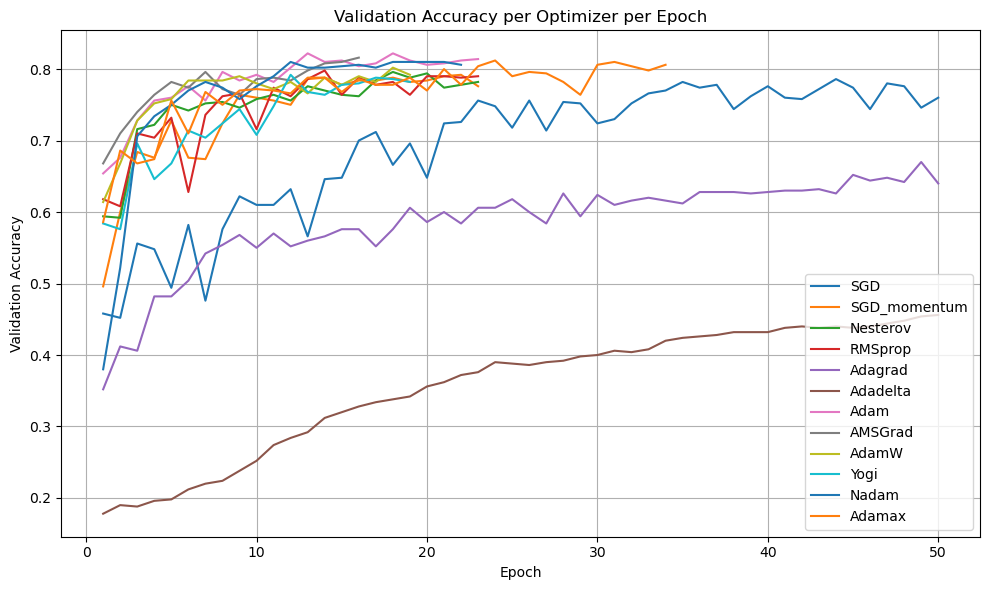

In [23]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Test Accuracy per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the validation accuracy history for this optimizer
    if 'val_accuracy' in result['history'].history:
        val_acc_history = result['history'].history['val_accuracy']
    else:
        # Sometimes the key might be 'val_acc', depending on TensorFlow version
        val_acc_history = result['history'].history.get('val_acc', [])

    # Plot the validation accuracy history
    plt.plot(range(1, len(val_acc_history) + 1), val_acc_history, label=optimizer_name)

plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy per Optimizer per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


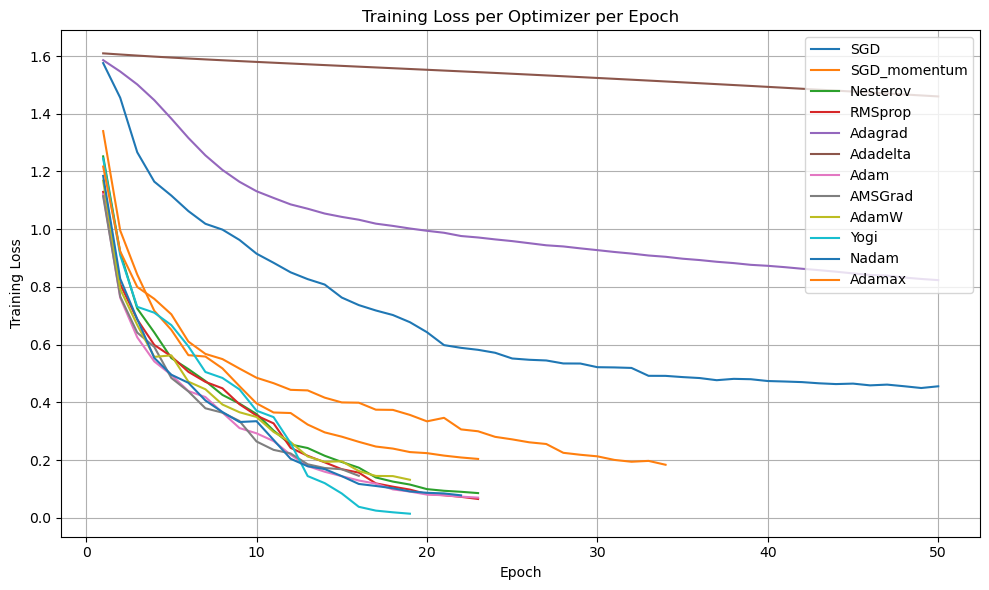

In [24]:
# Import necessary libraries
import matplotlib.pyplot as plt

# Plot Training Loss per Optimizer per Epoch
plt.figure(figsize=(10, 6))

# Loop through results to access each optimizer's training history
for optimizer_name, result in results.items():
    # Retrieve the training loss history for this optimizer
    if 'loss' in result['history'].history:
        loss_history = result['history'].history['loss']
    else:
        # In case the loss key isn't found (unexpected behavior), use a default empty list
        loss_history = []

    # Plot the training loss history
    plt.plot(range(1, len(loss_history) + 1), loss_history, label=optimizer_name)

# Set plot labels and titles
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss per Optimizer per Epoch')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
final_df.to_csv('Flowers', index=False)